In [179]:
import numpy as np
import sys, os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import cv2
from skimage import morphology
from skimage.morphology import disk, square, dilation, erosion
from skimage import data
from skimage.feature import Cascade

In [180]:
test = False

In [181]:
def skinDetection(sourceImage):
    min_YCrCb = np.array([0,133,77],np.uint8)
    max_YCrCb = np.array([255,173,127],np.uint8)

    # Convert image to YCrCb
    imageYCrCb = cv2.cvtColor(sourceImage,cv2.COLOR_RGB2YCR_CB)

    # Find region with skin tone in YCrCb image
    skinRegion = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)

    # Do contour detection on skin region
    contours, hierarchy = cv2.findContours(skinRegion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contour on the source image
    max_contour_area = -1
    max_contour_index = -1
    for i, c in enumerate(contours):
        area = cv2.contourArea(c)
        if area > max_contour_area:
            max_contour_index = i
            max_contour_area = area
    sourceImage = np.zeros(sourceImage.shape).astype(sourceImage.dtype)
    if max_contour_index > -1: 
        cv2.drawContours(sourceImage, contours, max_contour_index, (255, 255, 255), -1)
    sourceImage = cv2.cvtColor(sourceImage,cv2.COLOR_RGB2GRAY)
    return sourceImage

In [182]:
def skinMask(image_RGB):
    skin_seg = skinDetection(image_RGB)
    return skin_seg

The eye map from the chroma is based on the observation that high Cb  and low Cr values are found around the eyes. It is constructed by 
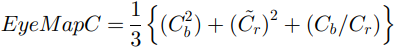
where $C_b^{2} $ , $(255-C_r)^{2} $ , $C_b/C_r $ , all are normalized to the range [0, 255]

In addition, eyes contain bright and dark values in the luminance component; therefore, grayscale dilation and erosion with ball structuring elements are used to construct EyeMapL.EyeMapL is calculated as follows:
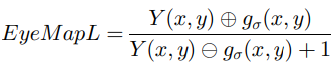

Then, EyeMapC is multiplied by EyeMapL to obtain EyeMap


The eye map is then dilated, masked, and normalized to brighten both the eyes and suppress other facial areas.

In [183]:
def locateEye(image_RGB):
    
    # transform the image to the YCbCr space
    image_YCrCb = cv2.cvtColor(image_RGB, cv2.COLOR_RGB2YCR_CB)
    
    # extracting YCbCr space components
    Y = image_YCrCb[:,:,0]
    Cr = np.asarray(image_YCrCb[:,:,1], np.int16)
    Cb = np.asarray(image_YCrCb[:,:,2], np.int16)
    
    # calculating the EyeMapC
    val_1 = np.power(Cb,2)
    val_1 = val_1/(np.amax(val_1)/255.0)

    val_2 = np.power(255-Cr,2)
    val_2 = val_2/(np.amax(val_2)/255.0)

    val_3 = Cb/Cr
    val_3 = val_3/(np.amax(val_3)/255.0)

    EyeMapC = (val_1+val_2+val_3)/3
    
    # calculating the EyeMapL
    mask = disk(5)
    image_gray = cv2.cvtColor(image_RGB, cv2.COLOR_RGB2GRAY)
    image_dilation = dilation(image_gray, selem=mask)
    image_erosion = erosion(image_gray, selem=mask)
    
    EyeMapL = (image_dilation/(image_erosion+1))
    
    # calculating the EyeMap
    EyeMap = EyeMapC*EyeMapL
    EyeMap = EyeMap/(np.amax(EyeMap)/255.0)
    
    # EyeMap processing
    mask = disk(5)
    EyeMap_dilation = dilation(EyeMap, selem=mask)
    
    skin = skinMask(image_RGB)
    mask = disk(20)
    skin = erosion(skin, selem=mask)
    
    EyeMap_dilation_mask = cv2.bitwise_and(EyeMap_dilation,  EyeMap_dilation,mask =skin)

    result = np.asarray(EyeMap_dilation_mask, dtype='uint8')
    ret2,eyes = cv2.threshold(result,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    if test == True:
        # plot image  in YCbCr space
        plt.figure(figsize=(10,7))
        plt.subplot(121)
        plt.imshow(image_RGB)
        plt.title("Original image in YCbCr space")
        plt.subplot(122)
        plt.imshow(image_YCrCb)
        plt.title("Original image in YCbCr space")
        plt.show()
        
        # plot image components in YCbCr space
        plt.figure(figsize=(10,7))
        plt.subplot(131)
        plt.imshow(Y,cmap="gray")
        plt.title("Image in YCrCb - Y")
        plt.subplot(132)
        plt.imshow(Cb,cmap="gray")
        plt.title("Image in YCrCb - Cb")
        plt.subplot(133)
        plt.imshow(Cr,cmap="gray")
        plt.title("Image in YCrCb - Cr")
        plt.show()
        
        # plot EyeMapC terms
        plt.figure(figsize=(10,7))
        plt.subplot(131)
        plt.imshow(val_1,cmap="gray")
        plt.title("$C_b^{2} $")
        plt.subplot(132)
        plt.imshow(val_2,cmap="gray")
        plt.title("$(255-C_r)^{2} $")
        plt.subplot(133)
        plt.imshow(val_3,cmap="gray")
        plt.title("$C_b/C_r$")
        plt.show()
        
        # plot EyeMapC
        plt.imshow(EyeMapC,cmap="gray")
        plt.title("EyeMapC")
        plt.show()
        
        # plot EyeMapL terms
        plt.figure(figsize=(10,7))
        plt.subplot(131)
        plt.imshow(image_gray,cmap="gray")
        plt.title("Original image in gray scale")
        plt.subplot(132)
        plt.imshow(image_erosion,cmap="gray")
        plt.title("Erosion")
        plt.subplot(133)
        plt.imshow(image_dilation,cmap="gray")
        plt.title("Dilation")
        plt.show()
        
        # plot Skin Mask:
        plt.imshow(skin,cmap="gray")
        plt.title("Skin Mask")
        plt.show()
        
        # plot EyeMap:
        plt.figure(figsize=(10,7))
        plt.subplot(131)
        plt.imshow(EyeMap,cmap="gray")
        plt.title("EyeMap")
        plt.subplot(132)
        plt.imshow(EyeMap_dilation,cmap="gray")
        plt.title("EyeMap after dilation")
        plt.subplot(133)
        plt.imshow(EyeMap_dilation_mask,cmap="gray")
        plt.title("EyeMap after dilation and masking")
        plt.show()
        
        plt.imshow(eyes,cmap="gray")
        plt.title("Eyes")
        plt.show()
    return eyes

The color of mouth region contains stronger red component and weaker blue component than other facial regions. Hence, the chrominance component $C_r $ is greater than $C_b $ in the mouth region. In addition, the mouth has a realtively low response in the $C_r/C_b $ feature, but it has high responce in $C_r^{2} $. The map can be constructed as follows
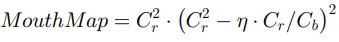
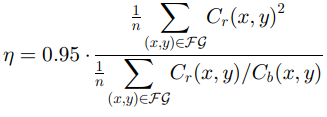

In [184]:
def locateMouth(image_RGB):
    # transform the image to the YCbCr space
    image_YCrCb = cv2.cvtColor(image_RGB, cv2.COLOR_RGB2YCR_CB)
    
    # extracting YCbCr space components
    Y = image_YCrCb[:,:,0]
    Cr = np.asarray(image_YCrCb[:,:,1], np.int16)
    Cb = np.asarray(image_YCrCb[:,:,2], np.int16)
    
    skin = skinMask(image_RGB)
    
    # calculating the MouthMap
    n = np.count_nonzero(skin==255)
    eta = 0.95 * np.sum(np.power(Cr[skin==255],2))/np.sum(np.divide(Cr[skin==255],Cb[skin==255]))
    
    val_1 = np.power(Cr,2)
    val_1 = val_1/(np.amax(val_1)/255.0)

    val_2 = Cr/Cb
    val_2 = val_2/(np.amax(val_2)/255.0)

    MouthMap = val_1 * np.power(val_1 - eta * val_2, 2)
    MouthMap = MouthMap/(np.amax(MouthMap)/255.0)
    
    # plot Skin Mask:
    plt.imshow(skin,cmap="gray")
    plt.title("Skin Mask")
    plt.show()
    
    # plot MouthMap terms
    plt.figure(figsize=(10,7))
    plt.subplot(131)
    plt.imshow(val_1,cmap="gray")
    plt.title("$C_r^{2} $")
    plt.subplot(132)
    plt.imshow(val_2,cmap="gray")
    plt.title("$C_r/C_b$")
    plt.subplot(133)
    plt.imshow(MouthMap,cmap="gray")
    plt.title("MouthMap")
    plt.show()
    
    return MouthMap

In [185]:
def locateMouth2(image_RGB):
    
    rows = image_RGB.shape[0]
    cols = image_RGB.shape[1]
    
    ROI = image_RGB[(2*rows)//3:rows,(cols)//3:(2*cols)//3]
    plt.imshow(ROI)
    plt.title("ROI")
    plt.show()
    
    R = ROI[:,:,0]
    G = np.asarray(ROI[:,:,1], np.int16)
    B = np.asarray(ROI[:,:,2], np.int16)
    
    MouthMap = 2 * np.arctan((R-G)/R)/np.pi
    MouthMap = MouthMap/(np.amax(MouthMap)/255.0)
    #print(MouthMap)
    MouthMap = np.asarray(MouthMap, dtype='uint8')
    ret2,MouthMap = cv2.threshold(MouthMap,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return MouthMap

In [186]:
def locateMouth3(image_RGB):
    image_GRAY = cv2.cvtColor(image_RGB, cv2.COLOR_RGB2GRAY)
    
    plt.imshow(image_GRAY,cmap="gray")
    plt.title("image_GRAY")
    plt.show()
    
    xp = [0, 64, 128, 192, 255]
    fp = [0, 16, 128, 240, 255]
    x = np.arange(256)
    table = np.interp(x, xp, fp).astype('uint8')
    image_GRAY = cv2.LUT(image_GRAY, table)
    
    plt.imshow(image_GRAY,cmap="gray")
    plt.title("image_GRAY")
    plt.show()

## Testing with one image

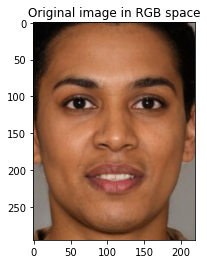

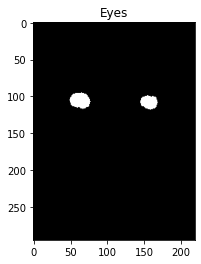

Text(0.5, 1.0, 'Eyes')

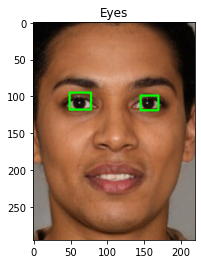

In [187]:
image_RGB = np.asarray(mpimg.imread("face.jpg"),np.uint8)
plt.imshow(image_RGB)
plt.title("Original image in RGB space")
plt.show()
eyes = locateEye(image_RGB)
plt.imshow(eyes,cmap="gray")
plt.title("Eyes")
plt.show()
contours, hierarchy = cv2.findContours(eyes, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
eyes = (cv2.cvtColor(eyes, cv2.COLOR_GRAY2RGB))
#cv2.drawContours(eyes, contours, -1, (0,255,0), 3)
#plt.imshow(eyes)
#plt.title("Eyes")
#plt.show()
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    bounding_rectangle = cv2.rectangle(image_RGB, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.imshow(bounding_rectangle)
plt.title("Eyes")

In [188]:
## Testing using webcam

In [189]:
haar_file = 'haarcascade_frontalface_default.xml'

#'0' is used for my webcam,
# if you've any other camera
#  attached use '1' like this
webcam = cv2.VideoCapture(0)

face_cascade = cv2.CascadeClassifier(haar_file)
 
# The program loops until it has 30 images of the face.
count = 1
cv2.namedWindow("output", cv2.WINDOW_NORMAL) 
while True:
    (_, im) = webcam.read()
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(gray, 1.3, 4)
    l = 0
    for (x, y, w, h) in faces:
        face = cv2.cvtColor(im[y :y + h , x :x + w ], cv2.COLOR_BGR2RGB)
        cv2.rectangle(im, (x, y), (x + w, y + h), (255, 0, 0), 2)
        
        eyes = locateEye(face)

        contours, hierarchy = cv2.findContours(eyes, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        l = len(contours)
        for contour in contours:
            x_c,y_c,w_c,h_c = cv2.boundingRect(contour)
            x_c += x
            y_c += y
            bounding_rectangle = cv2.rectangle(im, (x_c, y_c), (x_c + w_c, y_c + h_c), (0, 255, 0), 2)
        break
        
    
    cv2.imshow('output', im)
    key = cv2.waitKey(10)
    if key == 27:
        break
cv2.destroyAllWindows()
webcam.release()

# Old Methods

In [3]:
def skinDetection(image_RGB):
    """
    min_HSV = np.array([0, 58, 30], dtype = "uint8")
    max_HSV = np.array([33, 255, 255], dtype = "uint8")
    imageHSV = cv2.cvtColor(image_RGB, cv2.COLOR_RGB2HSV)
    skinRegionHSV = cv2.inRange(imageHSV, min_HSV, max_HSV)

    skin = cv2.bitwise_and(image_RGB, image_RGB, mask = skinRegionHSV)
    ret2,skin_seg = cv2.threshold(cv2.cvtColor(skin, cv2.COLOR_RGB2GRAY),0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    """
    # Constants for finding range of skin color in YCrCb
    min_YCrCb = np.array([0,133,77],np.uint8)
    max_YCrCb = np.array([255,173,127],np.uint8)
    
    # Convert image to YCrCb
    imageYCrCb = cv2.cvtColor(image_RGB,cv2.COLOR_RGB2YCR_CB)

    # Find region with skin tone in YCrCb image
    skinRegion = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
    
    return skinRegion

In [23]:
def skinMask(image_RGB):
        skin_seg = skinDetection(image_RGB)
        mask = square(15)
        skin_seg = dilation(skin_seg, selem=mask)
        skin_seg = dilation(skin_seg, selem=mask)
        return skin_seg